# O carro está batido ou não?

# Autor
Nome: Leonardo Fernandes Padre

Matrícula: 200067036

# Objetivo
Artigo com o objetivo de explicar de forma sucinta o passo a passo para contrução de um modelo com o objetivo de reconhecer se um carro está novo ou se possui alguma avaria.

# Motivação
Com o crescimento do mercado digital, muitas empresas de venda de carros usados surgiram. Na intenção de melhorar a experiência do usuário, esse modelo pode ser utilizado para aperfeiçoar a página de busca por carros, deixando os com avaria em abas diferentes e com avisos visíveis para o usuário.

# Desenvolvimento
Este modelo foi todo desenvolvido na ferramenta [Google Colab](https://colab.research.google.com), disponível para navegador. Utilizando o [pip](https://pypi.org/project/pip/) como instalador de pacotes.


## Baixando e Importando Pacotes
Utilizaremos 3 pacotes para o desenvolvimento do modelo
> fastai

Utilizado para todo contexto relacionado ao modelo

> duckduckgo_search

Necessário para baixar as URLs das imagens para o treinamento e execução

> fastbook

Pacote necessário na criação da base de dados

In [12]:
# -qq tem o propósito de mostrar apenas logs de erros criticos
!pip install -qq fastai
!pip install -qq duckduckgo_search
!pip install -qq fastbook

from fastai.vision.all import *
import duckduckgo_search
from fastbook import *
from fastdownload import download_url

## Criando a Base de Dados
A partir de agora é iniciado o processo de download das imagens que serão os dados utilizados para o treinamento do modelo. Será utilizado funções da biblioteca `duckduckgo_search` para pesquisa e download a partir dos rótulos contidos na variável `lbs`.

Ao longo do desenvolvimento desse modelo, foi notado pelo autor que adicionar rótulos em inglês melhorava os resultados futuros do mesmo.

In [13]:
lbs = 'crashed-car', 'new-car'
path = Path('crashed-or-not')

for o in lbs:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images_ddg(o, max_images=100))

## Treinando o Modelo
Visando melhorar o desempenho do modelo, a próxima célula de código tem o objetivo de verificar se existe algum download corrompido, caso haja, removê-los. Nesse caso, existem 10 arquivos corrompidos.

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'Falhas Removidas: {len(failed)}')

Falhas Removidas: 10


`DataLoaders` são objetos que contém 2 tipos de conjuntos (treinamento e validação), utilizados para criar o modelo e verificar a precisão do mesmo. A próxima célula de código cria um `DataLoader` usando um `DataBlock` e mostra as imagens de amostra dele.

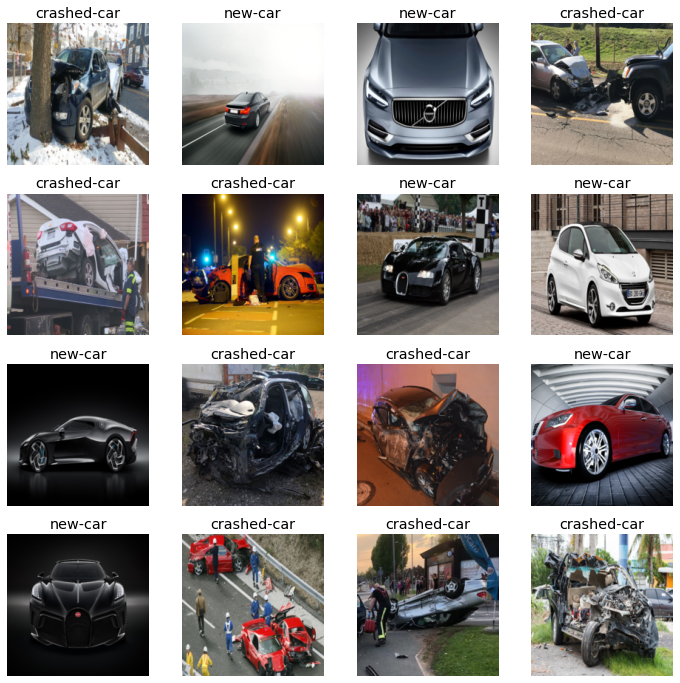

In [15]:
dls = DataBlock (
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192, method = 'squish')]
).dataloaders(path, bs = 32)

dls.show_batch(max_n = 16)

### Parametros do `DataBlock`

O bloco em sí, contendo uma imagem como entrada e o rótulo como saída
> blocks = (ImageBlock, CategoryBlock)

Tem o objetivo de encontrar todas as entradas para o modelo
> get_items = get_image_files

Divide os dados entre os 2 conjuntos de forma randomica, separando 20% dos mesmos para validação
> splitter = RandomSplitter(valid_pct = 0.2, seed = 42)

Utiliza como rótulo o nome da pasta onde se encontra cada arquivo
> get_y = parent_label

Tem por objetivo redimensionar a imagem para 192x192 pixels esmagando-a(squish)
> item_tfms = [Resize(192, method = 'squish')]

Após todas as configurações utilizaremos a função `vision_learner`, onde passaremos como parâmetro os `DataLoaders`, o modelo de visão computacional que será utilizado (`resnet18`) e as métricas. Além disso, foi utilizado o método `fine_tune`, disponibilizado pelo `fastai` para ajustar um modelo pré-treinado usando as melhores práticas.

In [16]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.430890,0.094830,0.028037,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.056277,0.000881,0.000000,02:01
1,0.028852,0.000381,0.000000,02:09
2,0.018353,0.000123,0.000000,02:02
3,0.012356,0.000156,0.000000,02:00
4,0.008581,0.000152,0.000000,02:03


## Use o modelo
A partir de uma imagem baixada fora do nosso banco de dados, faremos a utilização do modelo

This is a: crashed-car.
Probability of being a crashed-car: 0.9998


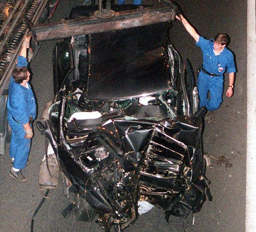

In [17]:
urls = search_images_ddg('crashed car photos', max_images=1)
dest = 'crashed_car.jpg'
download_url(urls[0], dest, show_progress=False)

car_status,_,probs = learn.predict(PILImage.create('crashed_car.jpg'))

print(f"This is a: {car_status}.")
print(f"Probability of being a {car_status}: {probs[0]:.4f}")

img = Image.open(dest)
img.to_thumb(256,256)